# Rede Convolucional similar a LeNet aplicada no MNIST

Neste notebook iremos utilizar uma rede convolucional similar à rede LeNet para treinar e classificar o conjunto de dados do MNIST.

## Importando as bibliotecas

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import numpy as np
import sys,os
import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense, Dropout
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.datasets import mnist

sys.path.append('../src')
from my_keras_utilities import (get_available_gpus, 
                                load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

Using TensorFlow backend.


In [2]:
import keras.backend as K
K.set_image_data_format('channels_first')
K.set_floatx('float32')
print('Backend:        {}'.format(K.backend()))
print('Data format:    {}'.format(K.image_data_format()))
print('Available GPUS:', get_available_gpus())
!nvidia-smi

Backend:        tensorflow
Data format:    channels_first
Available GPUS: []
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Código de apoio ao treinamento

In [3]:
class MyCb(TrainingPlotter):
    
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)


def train_network(model, X_train, y_train, Xval, yval, 
                  model_name = None,
                  loss="categorical_crossentropy",
                  opt='rmsprop', batch_size=60, nepochs=100, patience=10, nr_seed=20170522, 
                  reset=False, ploss=1.0):

    do_plot = (ploss > 0.0)
    
    model_fn = model_name + '.model'
    if reset and os.path.isfile(model_fn):
        os.unlink(model_name + '.model')
        
    if not os.path.isfile(model_fn):
        # initialize the optimizer and model
        print("[INFO] compiling model...")
        model.compile(loss=loss, optimizer=opt, metrics=["accuracy"])    

        # History, checkpoint, earlystop, plot losses:
        cb = MyCb(n=1, filepath=model_name, patience=patience, plot_losses=do_plot)
        
    else:
        print("[INFO] loading model...")
        model, cb = load_model_and_history(model_name)
        cb.patience = patience

    past_epochs = cb.get_nepochs()
    tr_epochs = nepochs - past_epochs
    
    if do_plot:
        import matplotlib.pyplot as plot
        vv = 0
        fig = plot.figure(figsize=(15,6))
        plot.ylim(0.0, ploss)
        plot.xlim(0, nepochs)
        plot.grid(True)
    else:
        vv = 2

    print("[INFO] training for {} epochs...".format(tr_epochs))
    try:
        h = model.fit(X_train, y_train, batch_size=60, epochs=tr_epochs, verbose=0, 
                      validation_data=(Xval, yval), callbacks=[cb])
    except KeyboardInterrupt:
        pass
    model, cb = load_model_and_history(model_name)
    return model, cb

def test_network(model_name, X_test, y_test):
    model, histo = load_model_and_history(model_name)
    print('Model from epoch {}'.format(histo.best_epoch))
    print("[INFO] evaluating in the test data set ...")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
    print("\n[INFO] accuracy on the test data set: {:.2f}% [{:.5f}]".format(accuracy * 100, loss))

## Leitura e normalização do dataset MNIST

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 28, 28) / 255.0
X_test = X_test.reshape(-1, 1, 28, 28) / 255.0

print('Treino:',X_train.shape, y_train.shape)
print('Teste:',X_test.shape, y_test.shape)

Treino: (60000, 1, 28, 28) (60000,)
Teste: (10000, 1, 28, 28) (10000,)


## Pequena amostra, apenas para testar o código

In [5]:
if True:
    n_samples_train = 1000
    n_samples_test  = 500

    X_train = X_train[:n_samples_train]
    y_train = y_train[:n_samples_train]
    X_test = X_test[:n_samples_test]
    y_test = y_test[:n_samples_test]

## Conventendo para one-hot encoding

In [6]:
y_train_oh = np_utils.to_categorical(y_train, 10)
y_test_oh = np_utils.to_categorical(y_test, 10)

print('Treino:',X_train.shape, y_train_oh.shape)
print('Teste:',X_test.shape, y_test_oh.shape)

Treino: (1000, 1, 28, 28) (1000, 10)
Teste: (500, 1, 28, 28) (500, 10)


## Criação do modelo da rede

<img src = '../figures/Rede_LeNet_like.png', width=600pt></img>

<table align='left'>
<tr><td> <img src="https://drive.google.com/uc?id=0By1KMDFVxsI2UlFPQ1R4S3poMWc"> </td></tr>
</table>

In [7]:
def build():
    model = Sequential()

    # first set of CONV => RELU => MAXPOOL
    model.add(Conv2D(20, (5, 5), padding="same", 
                     input_shape=(1, 28, 28)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # second set of CONV => RELU => MAXPOOL
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.5))

    # set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(50))
    model.add(Activation("relu"))

    # softmax classifier
    model.add(Dense(10))
    model.add(Activation("softmax"))

    return model

model = build()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 28, 28)        520       
_________________________________________________________________
activation_1 (Activation)    (None, 20, 28, 28)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 14, 14)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 14, 14)        25050     
_________________________________________________________________
activation_2 (Activation)    (None, 50, 14, 14)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 7, 7)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 7, 7)          0         
__________

## Laço de treinamento

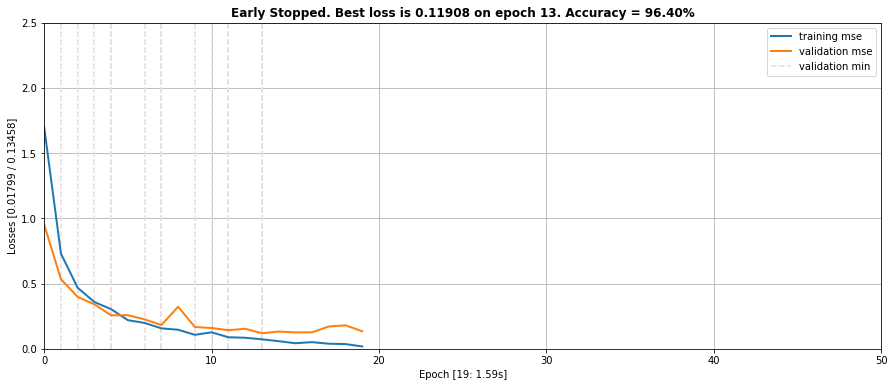

In [8]:
model_name = '../../models/keras_lenet_1'
fit_params = {
    'model_name': model_name,
    'loss':       'categorical_crossentropy',
    'opt':        RMSprop(),
    'batch_size': 128, 
    'nepochs':    50,
    'patience':   5,
    'ploss':      2.5,
    'reset':      False,
}

model_trained,_ = train_network(model, X_train, y_train_oh, X_test, y_test_oh, **fit_params);

In [9]:
print('Rótulos conj. teste:',y_test[:10])
y_hat = model_trained.predict_classes(X_test,verbose=0)
print('Rótulos previstos:  ',y_hat[:10])

Rótulos conj. teste: [7 2 1 0 4 1 4 9 5 9]
Rótulos previstos:   [7 2 1 0 4 1 4 9 5 9]


## Acurácia no conjunto de teste

In [10]:
test_network(model_name, X_test, y_test_oh)

Model from epoch 13
[INFO] evaluating in the test data set ...
500/500 [==============================] - 0s     

[INFO] accuracy on the test data set: 96.40% [0.11908]


In [11]:
y_prob = model_trained.predict_proba(X_test).max(axis=1)
y_hat = model_trained.predict_classes(X_test)
acc = (y_hat == y_test).sum()/y_test.size
print('Acurácia:', acc)

500/500 [==============================] - 0s     
Acurácia: 0.964


## Predições certas com maior probabilidade

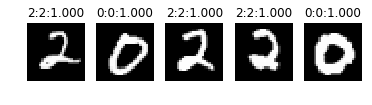

In [12]:
i_ok = np.where(y_hat==y_test)[0]
top_most_ok = np.argsort(y_prob[i_ok])[-5:][::-1]
y_top5 = i_ok[top_most_ok]
for k,i in enumerate(y_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i][0],cmap='gray')
    plt.title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições certas com menor probabilidade

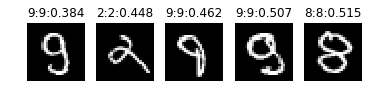

In [13]:
i_ok = np.where(y_hat==y_test)[0]
top_least_ok = np.argsort(y_prob[i_ok])[:5]
y_bot5 = i_ok[top_least_ok]
for k,i in enumerate(y_bot5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i][0],cmap='gray')
    plt.title('{}:{}:{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições erradas com maior probabilidade

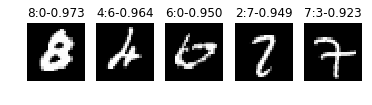

In [14]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_most_not_ok = np.argsort(y_prob[i_not_ok])[-5:][::-1]
y_most_not_ok_top5 = i_not_ok[top_most_not_ok]

for k,i in enumerate(y_most_not_ok_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i][0],cmap='gray')
    plt.title('{}:{}-{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Predições erradas com menor probabilidade

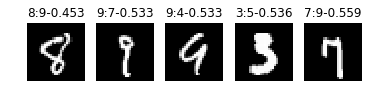

In [15]:
i_not_ok = np.where(y_hat!=y_test)[0]
top_least_not_ok = np.argsort(y_prob[i_not_ok])[:5]
y_least_not_ok_top5 = i_not_ok[top_least_not_ok]

for k,i in enumerate(y_least_not_ok_top5):
    plt.subplot(1, 5, k + 1)
    plt.imshow(X_test[i][0],cmap='gray')
    plt.title('{}:{}-{:0.3f}'.format(y_test[i],y_hat[i],y_prob[i]))
    plt.axis('off')

## Atividades

1. Calcular o número de parâmetros a serem treinados nesta rede e verificar se confere com o sumário da rede
2. Mostrar a matriz de confusão da rede aplicada no conjunto de testes


## Aprendizados com este notebook
